## Initial notebook for project 

In [15]:
# Imports and set up
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
import matplotlib.pyplot as plt
from torcheeg.io.eeg_signal import EEGSignalIO
from sklearn.model_selection import train_test_split

## Path to dir with data (remember the last '/')
path = "../data/"

## Establish connection to datafile
IO = EEGSignalIO(io_path=str(path), io_mode='lmdb')
## Read metadata dataframeimports
metadata = pd.read_csv(path + 'sample_metadata.tsv', sep='\t')

In [16]:
# Verifying connextion to data
idxs = np.arange(len(metadata))

X = torch.FloatTensor(np.array([IO.read_eeg(str(i)) for i in idxs]))
print(f"nsamples: {X.shape[0]}  -  nchannels: {X.shape[1]}  -  t: {X.shape[2]}")

y = torch.tensor(metadata["value"].values, dtype=torch.long)

nsamples: 5184  -  nchannels: 22  -  t: 800


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print(f"shape of X train: {X_train.shape}")
print(f"shape of X val: {X_val.shape}")
print(f"shape of X test: {X_test.shape}")

print(f"shape of y train: {y_train.shape}")
print(f"shape of y val: {y_val.shape}")
print(f"shape of y test: {y_test.shape}")

shape of X train: torch.Size([3110, 22, 800])
shape of X val: torch.Size([1037, 22, 800])
shape of X test: torch.Size([1037, 22, 800])
shape of y train: torch.Size([3110])
shape of y val: torch.Size([1037])
shape of y test: torch.Size([1037])


In [18]:
#set up of matrixies 
#number of samples, channels, and timesteps
nsamples_train, nchannels_train, t = X_train.shape
nsamples_val, nchannels_val, t = X_val.shape

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

adj_matrix_train = torch.eye(nchannels_train)
adj_matrix_val = torch.eye(nchannels_val)

In [19]:
class GraphConv(nn.Module):
    def __init__(self, in_features, out_features):
        super(GraphConv, self).__init__()
        self.weight = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = nn.Parameter(torch.zeros(out_features))

    def forward(self, x, adj):
        x = torch.matmul(adj, x)  
        x = torch.matmul(x, self.weight) + self.bias  
        return torch.relu(x)

class EEG_GNN(nn.Module):
    def __init__(self, in_features, hidden_dim, nclasses, nchannels):
        super(EEG_GNN, self).__init__()
        self.conv1 = GraphConv(in_features, hidden_dim)
        self.batch_norm1 = nn.BatchNorm1d(nchannels) 
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.batch_norm2 = nn.BatchNorm1d(nchannels) 
        self.conv3 = GraphConv(hidden_dim, nclasses)  

    def forward(self, x, adj):
        x = self.conv1(x, adj)
        x = self.batch_norm1(x)  
        x = F.relu(x)
        x = self.conv2(x, adj)
        x = self.batch_norm2(x)  
        x = F.relu(x)
        x = self.conv3(x, adj)  
        x = x.mean(dim=1)  
        return x

In [20]:
print(adj_matrix_train.shape)
print(type(adj_matrix_train))
print(nsamples_train)

print(adj_matrix_val.shape)
print(type(adj_matrix_val))
print(nsamples_val)

torch.Size([22, 22])
<class 'torch.Tensor'>
3110
torch.Size([22, 22])
<class 'torch.Tensor'>
1037


In [21]:
def get_adj_by_corr(data, nsamples, threshold=0.5):

    # Compute Pearson correlation between channels
    tmp_lst=[]
    
    for i in range(nsamples): 
        correlation_matrix = np.corrcoef(data[i])
        tmp_lst.append((correlation_matrix > threshold).astype(np.float32))
        
    # Convert correlation to adjacency matrix
    adj_mat = torch.from_numpy(np.array(tmp_lst))
    
    return adj_mat

In [22]:
class TrainGNN():
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def train_model(self, model, train_loader, val_loader, adjacency_matrix, learning_rate=0.0005, epochs=500, prints=True):
        model = model.to(self.device)
        adjacency_matrix = adjacency_matrix.to(self.device)  # Move adjacency to GPU if available

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        highest_train_accuracy = 0.0
        
        losses_train = []; losses_val = []

        for epoch in range(epochs):
            model.train()
            running_loss = 0.0; running_loss_val = 0.0
            correct = 0; correct_val = 0
            total = 0; total_val = 0
            
            for inputs, labels in train_loader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                optimizer.zero_grad()
                outputs = model(inputs, adjacency_matrix)  # Forward pass
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_accuracy = correct/total
            losses_train.append(epoch_loss)
            
            for inputs, labels in val_loader:
                outputs = model(inputs, adjacency_matrix)
                loss = criterion(outputs, labels)
                
                running_loss_val += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                
            epoch_loss_val = running_loss_val / len(val_loader.dataset)
            epoch_accuracy_val = correct_val/total_val
            losses_val.append(epoch_loss_val)
                
            if epoch_accuracy > highest_train_accuracy:
                highest_train_accuracy = epoch_accuracy

            if prints:
                print(f"Epoch {epoch+1}/{epochs}, Train loss: {epoch_loss:.4f}, Train acc: {(epoch_accuracy*100):.2f}%" +
                     f"| Val loss: {epoch_loss_val:.4f}, Val acc: {(epoch_accuracy_val*100):.2f}%")

        print(f"Highest Train Accuracy {(highest_train_accuracy*100):.2f}")
        torch.save(model.state_dict(), 'eeg_gnn.pth')
        
        losses = [losses_train, losses_val]

        return model, losses

In [ ]:
nclasses = y.max().item() + 1 
model = EEG_GNN(in_features=t, hidden_dim=32, nclasses=nclasses, nchannels=nchannels_train)

trainer = TrainGNN()
trained_model, losses = trainer.train_model(model, train_loader, val_loader, adj_matrix_train, epochs=20, prints=True)

Epoch 1/20, Train loss: 3.1305, Train acc: 22.35%| Val loss: 2.9394, Val acc: 20.54%
Epoch 2/20, Train loss: 2.7595, Train acc: 23.15%| Val loss: 2.6689, Val acc: 20.93%
Epoch 3/20, Train loss: 2.5006, Train acc: 23.63%| Val loss: 2.4650, Val acc: 21.79%
Epoch 4/20, Train loss: 2.3036, Train acc: 24.37%| Val loss: 2.3031, Val acc: 21.50%
Epoch 5/20, Train loss: 2.1476, Train acc: 25.08%| Val loss: 2.1732, Val acc: 22.18%
Epoch 6/20, Train loss: 2.0217, Train acc: 25.14%| Val loss: 2.0778, Val acc: 21.70%
Epoch 7/20, Train loss: 1.9226, Train acc: 25.66%| Val loss: 1.9907, Val acc: 21.60%
Epoch 8/20, Train loss: 1.8419, Train acc: 26.33%| Val loss: 1.9185, Val acc: 22.28%
Epoch 9/20, Train loss: 1.7773, Train acc: 27.11%| Val loss: 1.8682, Val acc: 22.47%
Epoch 10/20, Train loss: 1.7318, Train acc: 28.23%| Val loss: 1.8294, Val acc: 23.72%
Epoch 11/20, Train loss: 1.6939, Train acc: 28.04%| Val loss: 1.7952, Val acc: 23.24%
Epoch 12/20, Train loss: 1.6639, Train acc: 28.42%| Val loss: 1

In [26]:

def multirunmodel(trainer,epochs,nruns=10):
    '''
    Runs a models with the same hyperparameters but random training parameters

    ...
    
    Parameters
    ------------------
    trainer: TrainGNN
         training class for the model 
    paramlist : list
        list of all the parametors needed for the model
    nruns : int 
        How many runs it makes, default 10
    '''    
    modellist = [0 for x in range(nruns)]
    trainingdata = [0 for x in range(nruns)]
    for i in range(nruns):
        model = EEG_GNN(in_features=t, hidden_dim=32, nclasses=nclasses, nchannels=nchannels_train)
        trainer = TrainGNN()
        modellist[i],trainingdata[i] =  trainer.train_model(model, train_loader, val_loader, adj_matrix_train, epochs=epochs, prints=False)
    

    # plot
    fig, axs = plt.subplots(2, nruns//2, layout='constrained')

    for i in range(nruns//2):
        ax=axs[0][i]
        for j in range(len(trainingdata[i+nruns//2])):
                ax.plot(trainingdata[i+nruns//2][j])
        ax.set_title(f'Modelrun {i+nruns//2}')


        ax = axs[1][i]
        for j in range(len(trainingdata[i+nruns//2])):
                ax.plot(trainingdata[i+nruns//2][j])
        ax.set_title(f'Modelrun {i+nruns//2}')
    plt.show()

Highest Train Accuracy 61.06
Highest Train Accuracy 63.92
Highest Train Accuracy 65.82
Highest Train Accuracy 62.41


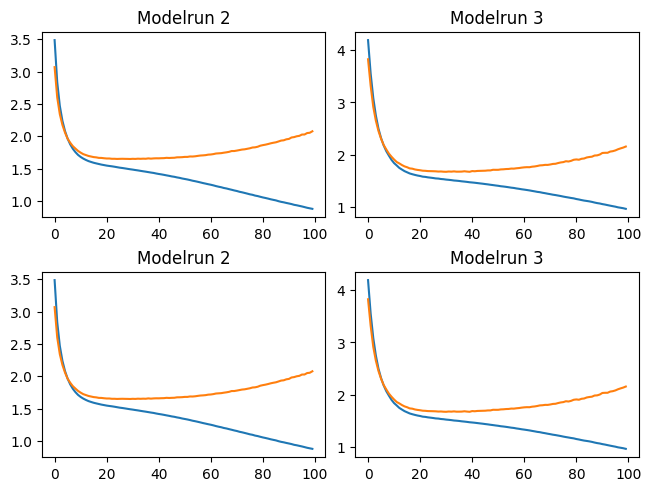

In [27]:

multirunmodel(trainer, 100,nruns=4)